In [1]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

2023-12-31 04:01:37.714148: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 04:01:37.714195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 04:01:37.715035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 04:01:37.723197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 04:01:38.763685: W tensorflow/compiler/tf2

In [2]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 250  # number of cycles to run

ALPHA = 0.1  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 128

TIME_STEP = 6

TIME_INTERVEL = 3

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [3]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [4]:
# !pip install librosa==0.8.1
import sys
sys.path.insert(1, '../Resources')

In [5]:
# lib.create_dataset_sep(audio_dir="../DATA/LSTM Train Test Split/Audio/train",segment_length=1 , csv_output_path='../DATA/LSTM Train Test Split/train_csv/')
# lib.create_dataset_sep(audio_dir="../DATA/LSTM Train Test Split/Audio/test",segment_length=1 , csv_output_path='../DATA/LSTM Train Test Split/test_csv/')

In [6]:
import numpy as np
np.__version__

'1.23.0'

In [7]:
import lib

In [8]:
label_encode = {"FAKE" : 0 , "REAL" : 1}

### Preparing Training Data

In [9]:
x_train = np.array([[[]]])
y_train = []
for i in os.listdir("../DATA/LSTM Train Test Split/train_csv"):
    df = pd.read_csv("../DATA/LSTM Train Test Split/train_csv/"+i)
    lbl = df['LABEL'][0]
    df = df.drop(columns = 'LABEL')
    
    if x_train.shape == (1, 1, 0):
        x_train, label = lib.reshape_data(df,time_interval=TIME_INTERVEL , time_step=TIME_STEP , label=label_encode[lbl])
        y_train.extend(label)
    else:
        new_data, label = lib.reshape_data(df,time_interval=TIME_INTERVEL , time_step=TIME_STEP, label=label_encode[lbl])
        y_train.extend(label)
        x_train = np.concatenate((x_train,new_data),axis=0)

x_train.shape

(1853, 6, 26)

In [10]:
y_train = np.array(y_train)
y_train = np.expand_dims(y_train , axis=1)
x_train.shape , y_train.shape

((1853, 6, 26), (1853, 1))

### Preparing Testing Data

In [11]:
x_test = np.array([[[]]])
y_test = []
for i in os.listdir("../DATA/LSTM Train Test Split/test_csv"):
    df = pd.read_csv("../DATA/LSTM Train Test Split/test_csv/"+i)
    lbl = df['LABEL'][0]
    df = df.drop(columns = 'LABEL')
    
    if x_test.shape == (1, 1, 0):
        x_test, label = lib.reshape_data(df,time_interval=TIME_INTERVEL , time_step=TIME_STEP , label=label_encode[lbl])
        y_test.extend(label)
    else:
        new_data, label = lib.reshape_data(df,time_interval=TIME_INTERVEL , time_step=TIME_STEP, label=label_encode[lbl])
        y_test.extend(label)

        x_test = np.concatenate((x_test,new_data),axis=0)

x_test.shape

(394, 6, 26)

In [12]:
y_test = np.array(y_test)
y_test = np.expand_dims(y_test , axis=1)
x_test.shape , y_test.shape

((394, 6, 26), (394, 1))

In [13]:
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
# o_sm = SMOTE()
# x_test_re, y_test_re = SMOTE().fit_resample(x_test, y_test)

### Build the Model

In [16]:
from keras.models import Sequential
from keras.layers import Dense , SimpleRNN

In [17]:
h_units = 128 # number of units in the RNN

input_shape=(TIME_STEP, x_train.shape[2] ) # we are using two features

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    input_shape = input_shape, 
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

2023-12-31 04:01:40.586984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 04:01:40.650618: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 04:01:40.650890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 04:01:40.652996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-31 04:01:40.653378: I external/local_xla/xla/stream_executor

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError() , 'accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               19840     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 19969 (78.00 KB)
Trainable params: 19969 (78.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
history = model.fit(x_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(x_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/250


2023-12-31 04:01:43.906245: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f32e1ad5440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-31 04:01:43.906351: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-12-31 04:01:43.914226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-31 04:01:43.939718: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1703975504.037927  148137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 [==============================] - 4s 55ms/step - loss: 1.2281 - root_mean_squared_error: 0.6105 - accuracy: 0.5532 - val_loss: 0.7879 - val_root_mean_squared_error: 0.5401 - val_accuracy: 0.5000
Epoch 2/250
15/15 [==============================] - 0s 10ms/step - loss: 0.7015 - root_mean_squared_error: 0.5034 - accuracy: 0.5348 - val_loss: 0.6856 - val_root_mean_squared_error: 0.4961 - val_accuracy: 0.5558
Epoch 3/250
15/15 [==============================] - 0s 11ms/step - loss: 0.6891 - root_mean_squared_error: 0.4980 - accuracy: 0.5532 - val_loss: 0.6933 - val_root_mean_squared_error: 0.5006 - val_accuracy: 0.4822
Epoch 4/250
15/15 [==============================] - 0s 10ms/step - loss: 0.6714 - root_mean_squared_error: 0.4892 - accuracy: 0.5969 - val_loss: 0.7004 - val_root_mean_squared_error: 0.5041 - val_accuracy: 0.4848
Epoch 5/250
15/15 [==============================] - 0s 10ms/step - loss: 0.6646 - root_mean_squared_error: 0.4859 - accuracy: 0.6222 - val_loss: 0.6925 - v

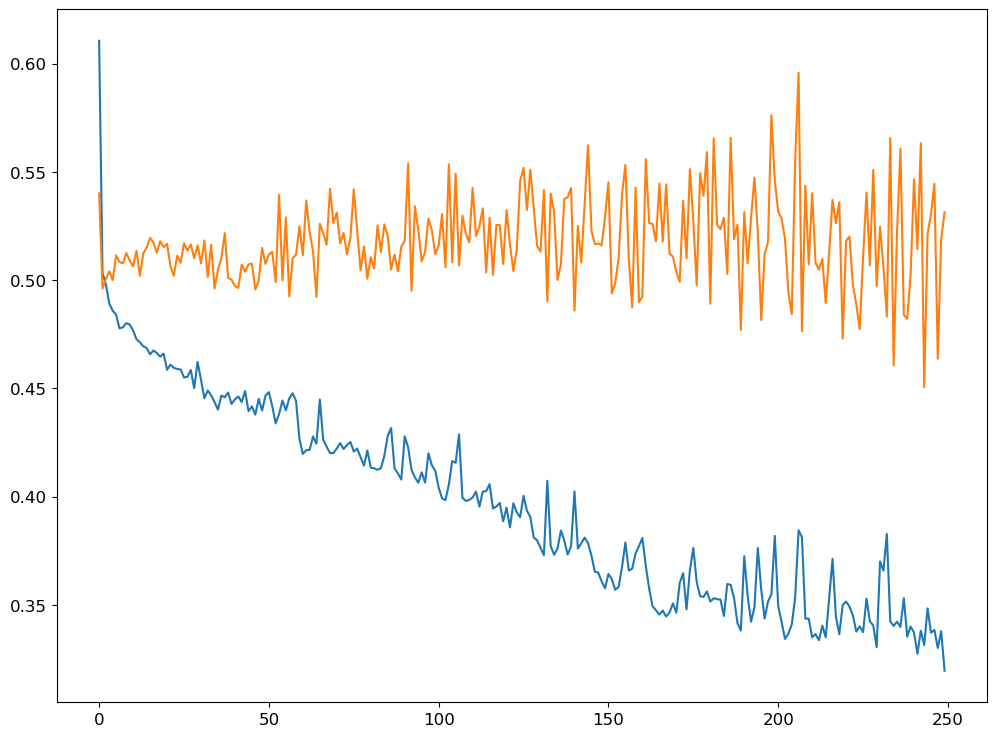

In [21]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)

hist_df
# plot_tf_hist(hist_df)

plt.plot(hist_df[['rmse','val_rmse']])

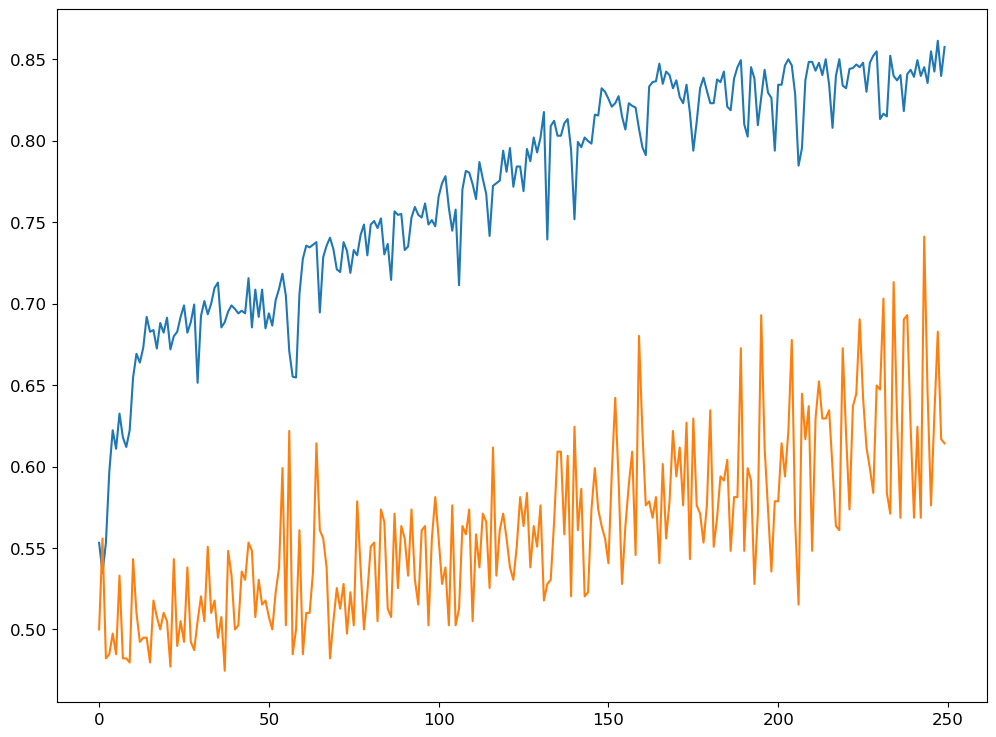

In [22]:
plt.plot(hist_df[['accuracy','val_accuracy']])

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay , classification_report

In [24]:
y_pred = model.predict(x_test)

13/13 [==============================] - 0s 3ms/step


In [25]:
y_pred_new = [] 
for i in y_pred:
    if i >=0.5:
        y_pred_new.append(1)
    else:
        y_pred_new.append(0)

In [26]:
accuracy_score(y_test , y_pred_new)

0.6142131979695431

In [27]:
CR = classification_report(y_pred=y_pred_new , y_true = y_test)
print(CR)

              precision    recall  f1-score   support

           0       0.57      0.99      0.72       197
           1       0.96      0.24      0.38       197

    accuracy                           0.61       394
   macro avg       0.76      0.61      0.55       394
weighted avg       0.76      0.61      0.55       394



In [28]:
x_val = np.array([[[]]])
y_val = []
for i in os.listdir("../DATA/LSTM Train Test Split/val"):
    df = pd.read_csv("../DATA/LSTM Train Test Split/val/"+i)
    lbl = df['LABEL'][0]
    df = df.drop(columns = 'LABEL')
    
    if x_val.shape == (1, 1, 0):
        x_val, label = lib.reshape_data(df,time_interval=TIME_INTERVEL , time_step=TIME_STEP , label=label_encode[lbl])
        y_val.extend(label)
    else:
        new_data, label = lib.reshape_data(df,time_interval=TIME_INTERVEL , time_step=TIME_STEP, label=label_encode[lbl])
        y_val.extend(label)

        x_val = np.concatenate((x_val,new_data),axis=0)

x_val.shape

(394, 6, 26)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
y_pred_val = model.predict(x_val)

13/13 [==============================] - 0s 4ms/step


In [31]:

y_pred_val_new = [] 
for i in y_pred_val:
    if i >=0.5:
        y_pred_val_new.append(1)
    else:
        y_pred_val_new.append(0)

In [32]:
len(y_val) , len(y_pred_val_new)

(394, 394)

In [33]:
accuracy_score(y_val , y_pred_val_new)

0.9670050761421319

In [34]:
CR = classification_report(y_pred=y_pred_val_new , y_true = y_val)
print(CR)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       197
           1       1.00      0.93      0.97       197

    accuracy                           0.97       394
   macro avg       0.97      0.97      0.97       394
weighted avg       0.97      0.97      0.97       394



In [35]:
cm = confusion_matrix(y_pred_val_new , y_val)

In [36]:
cm

array([[197,  13],
       [  0, 184]])

In [37]:
ConfusionMatrixDisplay(cm)

In [38]:
ConfusionMatrixDisplay?

Init signature: ConfusionMatrixDisplay(confusion_matrix, *, display_labels=None)
Docstring:     
Confusion Matrix visualization.

It is recommend to use
:func:`~sklearn.metrics.ConfusionMatrixDisplay.from_estimator` or
:func:`~sklearn.metrics.ConfusionMatrixDisplay.from_predictions` to
create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
attributes.

Read more in the :ref:`User Guide <visualizations>`.

Parameters
----------
confusion_matrix : ndarray of shape (n_classes, n_classes)
    Confusion matrix.

display_labels : ndarray of shape (n_classes,), default=None
    Display labels for plot. If None, display labels are set from 0 to
    `n_classes - 1`.

Attributes
----------
im_ : matplotlib AxesImage
    Image representing the confusion matrix.

text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text,             or None
    Array of matplotlib axes. `None` if `include_values` is false.

ax_ : matplotlib Axes
    Axes with confusion matrix.

figure_